In [1]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
import numpy as np
import torch
import dotenv
dotenv.load_dotenv()
# https://colab.research.google.com/drive/17dQFYUYnuKnP6OwQPH9v_GSYUW5aj-Rp#scrollTo=v6ZlLW2J5LA8

/mnt/align3_drive/adrianoh/miniconda3/envs/llm-density/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
torch.set_grad_enabled(False) # avoid blowing up mem

model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b",
    device_map='cuda',
)
tokenizer =  AutoTokenizer.from_pretrained("google/gemma-2-2b")

Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


In [3]:
# The input text
prompt = "Would you be able to travel through time using a wormhole?"

# Use the tokenizer to convert it to tokens. Note that this implicitly adds a special "Beginning of Sequence" or <bos> token to the start
inputs = tokenizer.encode(prompt, return_tensors="pt", add_special_tokens=True).to("cuda")
print(inputs)

# Pass it in to the model and generate text
outputs = model.generate(input_ids=inputs, max_new_tokens=50)
print(tokenizer.decode(outputs[0]))

tensor([[     2,  18925,    692,    614,   3326,    577,   5056,   1593,   1069,
           2177,    476,  47420,  18216, 235336]], device='cuda:0')
<bos>Would you be able to travel through time using a wormhole?

[Answer 1]

Yes, you can travel through time using a wormhole.

A wormhole is a theoretical object that connects two points in space-time. It is a tunnel through space-time that allows objects to travel from


In [4]:
from IPython.display import IFrame
html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

def get_dashboard_html(sae_release = "gemma-2-2b", sae_id="20-gemmascope-res-16k", feature_idx=0):
    return html_template.format(sae_release, sae_id, feature_idx)

html = get_dashboard_html(sae_release = "gemma-2-2b", sae_id="20-gemmascope-res-16k", feature_idx=10004)
IFrame(html, width=1200, height=600)

In [5]:
interp_latent_idx = 10_004 # we should use this one!
from sae_lens import SAE  # pip install sae-lens

sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = "gemma-scope-2b-pt-res-canonical",
    sae_id = "layer_20/width_16k/canonical",
)
sae.cuda()


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [6]:

def gather_residual_activations(model, target_layer, inputs):
  target_act = None
  def gather_target_act_hook(mod, inputs, outputs):
    nonlocal target_act # make sure we can modify the target_act from the outer scope
    target_act = outputs[0]
    return outputs
  handle = model.model.layers[target_layer].register_forward_hook(gather_target_act_hook)
  _ = model.forward(inputs)
  handle.remove()
  return target_act

In [7]:
target_act = gather_residual_activations(model, 20, inputs)
sae_acts = sae.encode(target_act.to(torch.float32))
recon = sae.decode(sae_acts)
1 - torch.mean((recon[:, 1:] - target_act[:, 1:].to(torch.float32)) **2) / (target_act[:, 1:].to(torch.float32).var())
(sae_acts > 1).sum(-1)

tensor([[7017,   47,   65,   70,   55,   72,   65,   75,   80,   72,   68,   93,
           86,   89]], device='cuda:0')

In [8]:
target_act.shape

torch.Size([1, 14, 2304])

In [9]:
values, inds = sae_acts.max(-1)

inds

tensor([[ 6631,  5482, 10376,  1670, 11023,  7562,  9407,  8399, 12935, 10004,
         10004, 10004, 12935,  3442]], device='cuda:0')

In [10]:
from transformer_lens.utils import tokenize_and_concatenate
from datasets import load_dataset
# dataset_name = "EleutherAI/the_pile_deduplicated" # too big?
# dataset_name = "stas/openwebtext-10k" # yolo
dataset_name = "PatrickHaller/pile-10M-words"
dataset = load_dataset(dataset_name, split="train", trust_remote_code=True) # Smaller version
# print(dataset)
# raise NotImplementedError("Stop here")
tokens = tokenize_and_concatenate(
    dataset=dataset,  # type: ignore
    tokenizer=tokenizer,  # type: ignore
    streaming=True,
    # NOTE: all these have context 128
    max_length=128, #sae.cfg.context_size,
    add_bos_token=True, #sae.cfg.prepend_bos,
)['tokens']
tokens = tokens.to('cuda') # eh 

In [11]:
tokens.shape

torch.Size([107803, 128])

In [12]:
model.eval()
for p in model.parameters():
    p.requires_grad = False
    p.grad = None

In [13]:
# turns out width over 2 works?
with torch.no_grad():
    model(tokens[:1])

In [14]:
try:
    del collected_outputs
except:
    pass
import gc
gc.collect()
torch.cuda.empty_cache()
import tqdm
collected_outputs = []
less_tokens = tokens[:10_000] # eh
def gather_target_act_hook(mod, inputs, outputs):
    global collected_outputs
    assert isinstance(outputs, tuple)
    assert len(outputs) == 1 and isinstance(outputs[0], torch.Tensor), f"Expected a single tensor output, got {outputs}" # fmt: skip
    collected_outputs.append(outputs[0].detach().requires_grad_(False).cpu())
    return outputs
handle = model.model.layers[20].register_forward_hook(gather_target_act_hook)
try:
    batch_size = 100
    for i in tqdm.trange(0, less_tokens.shape[0], batch_size):
        j = min(i + batch_size, less_tokens.shape[0])
        model.forward(less_tokens[i:j])
finally:
    handle.remove()
collected_outputs = torch.cat(collected_outputs, dim=0)
print(collected_outputs.shape)

100%|██████████| 100/100 [04:24<00:00,  2.65s/it]


torch.Size([10000, 128, 2304])


In [15]:
tokens_is_special = (less_tokens == tokenizer.bos_token_id) | (less_tokens == tokenizer.eos_token_id) | (less_tokens == tokenizer.pad_token_id)
# print(tokens_is_special.shape)
tokens_is_special_flat = tokens_is_special.cpu().flatten()
# print(tokens_is_special_flat.shape)
collected_outputs_flat = collected_outputs.cpu().reshape(-1, collected_outputs.shape[-1])
# print(collected_outputs_flat.shape)
activations = collected_outputs_flat[~tokens_is_special_flat, :]
print(activations.shape)

torch.Size([1266193, 2304])


In [16]:
activations = activations.to("cuda")


In [ ]:
relevant_idxs_and_names = [
    (10_004, "spacetime_latent_idx"),
    (15_947, "boolean_assignments_in_code"),
    (6_166, "conditional_statements_and_boolean_expressions"),
    (2_290, "boolean_declarations_and_related_expressions"),
    (6_223, "boolean_expressions_and_condition_checks"),
    (9_096, "syntax_related_to_boolean_operations_and_conditions"),
    (6_612, "instances_of_numbers_and_counting"),
    (13_046, "numbers_and_symbols_in_text"),
    (12_732, "instances_of_the_word_the_and_numbers"),
    (5_401, "references_to_numbers_and_quantitative_data"),
    (7_746, "numbers_and_quantities_related_to_time"),
    (6_850, "repetition_of_the_word_number"),
    (16_095, "references_to_number_one"),
    (11_520, "terms_and_definitions_related_to_numbers"),
    (6_010, "numbers_and_mathematical_operations"),
    (4_723, "numbers_and_specific_dates"),
    (2_437, "patterns_related_to_numerical_information"),
    (6_275, "numbers_and_numerical_values_in_context"),
    (15_031, "numbers_and_codes_related_to_legal_references"),
    (10_738, "phrases_related_to_numbers_and_mathematical_representations"),
    (2_269, "structured_lists_or_numbered_steps"),
    (11_576, "presence_of_numerical_values_or_references_to_numbered_steps"),
    (9_560, "numbers_and_their_combinations_in_various_contexts"),
    (11_669, "patterns_represented_by_sequences_of_numbers"),
    (12_115, "mentions_of_in_x_followed_by_a_number"),
    (1_561, "phrases_related_to_numbers_and_statistics"),
    (382, "numbers_and_their_associated_quantities"),
    (15_763, "sequences_of_numbers_and_their_occurrences"),
    (8_974, "phrases_indicating_quantity_or_comparison_involving_numbers"),
    (3_219, "numbers_and_their_associated_representations"),
    (2_260, "numbers_and_numerical_data"),
    (9_856, "numbers_associated_with_logical_operations"),
    (10_427, "numbers_and_their_formats"),
    (11_301, "integers_and_numbers_in_different_formats"),
    (11_626, "numbers_related_to_measurements_or_statistics"),
    (12_457, "sequences_of_numbers_and_codes_related_to_programming"),
    (12_841, "sequences_of_numbers_representing_activation_values"),
    (6_541, "numbers_and_numeric_expressions_in_academic_contexts"),
    (15_483, "numbers_dates_or_numerical_sequences"),
    (8_900, "numerical_information_related_to_phone_numbers"),
    (13_730, "numbers_and_alphanumeric_codes"),
    (14_853, "decimal_numbers_and_numeric_identifiers"),
    (972, "references_to_numbers_in_social_or_legal_context"),
    (12_852, "the_number_i_in_various_contexts"),
    (2_074, "numbers_represented_in_decimal_format"),
    (7_466, "presence_of_text_format_elements_like_numbers"),
    (16_183, "programming_functions_related_to_parsing_numbers"),
    (5_022, "code_snippets_related_to_phone_number_formatting"),
    (8_718, "numbers_and_symbols_in_non_standard_formats"),
    (43, "references_to_number_of_bedrooms"),
    (303, "mathematical_operations_related_to_rounding_numbers"),
    (723, "formatting_numbers_and_datetime_representations"),
    (1_589, "numbers_and_numerical_references_in_documents"),
    (6_057, "numbers_indicating_statistical_data"),
    (6_567, "sequences_of_numbers_and_code_structure"),
    (7_062, "integer_and_floating_point_numbers_in_programming"),
    (9_945, "occurrences_of_numbers_in_text"),
    (10_970, "numbers_and_their_operations_in_code"),
    (11_360, "contact_information_particularly_phone_numbers"),
    (11_663, "numbers_and_statistical_data_from_research"),
    (11_708, "references_to_phone_numbers"),
    (11_771, "references_to_section_numbers_in_documents"),
    (12_567, "specific_numeric_values_such_as_phone_numbers"),
    (14_355, "java_programming_constructs_for_numeric_data_types"),
    (10_779, "integers_related_to_success_or_completion_statuses"),
    (10_917, "declarations_of_integer_variables_in_programming"),
    (8_916, "terms_related_to_sizes_and_lengths"),
    (11_952, "phrases_that_emphasize_perspectives"),
    (2_579, "relational_conditions_involving_size_or_counts"),
    (10_999, "size_specifications_in_programming_contexts"),
    (6_276, "programming_syntax_dealing_with_sizes_and_dimensions"),
    (13_826, "screen_size_and_viewport_configurations"),
    (1_275, "terms_related_to_size_ranking_and_excellence"),
    (16_216, "references_to_size_and_dimensions"),
    (5_885, "phrases_emphasizing_outcomes_or_conclusions"),
    (14_202, "comparative_phrases_relating_to_size_or_status"),
    (5_862, "comparison_and_evaluation_about_size"),
    (7_508, "quantifiers_and_discussions_of_scale"),
    (7_097, "sentences_emphasizing_personal_reflections"),
    (387, "phrases_emphasizing_singular_focus"),
    (10_905, "repetitive_phrases_emphasizing_certainty"),
    (5_981, "phrases_emphasizing_significance_of_the"),
    (11_504, "comparisons_of_size_and_value"),
    (16_079, "adverbs_emphasizing_totality"),
    (1_058, "phrases_emphasizing_examples"),
    (9_348, "intensifiers_emphasizing_degree_or_quality"),
    (5_665, "phrases_emphasizing_totality"),
    (10_239, "references_to_size_or_magnitude"),
    (12_848, "measurements_related_to_distances_and_sizes"),
    (13_101, "intensifiers_emphasizing_attribute_degree"),
    (12_795, "bold_or_strongly_emphasized_text"),
    (640, "method_calls_related_to_size"),
    (1_323, "phrases_emphasizing_leadership"),
    (1_439, "variables_and_their_sizes_in_code"),
    (1_603, "intensifiers_emphasizing_quantity"),
    (4_385, "phrases_emphasizing_online_platforms"),
    (4_635, "phrases_emphasizing_value_creation"),
    (4_773, "phrases_emphasizing_personal_style"),
    (6_769, "phrases_emphasizing_beliefs_about_reality"),
    (6_829, "phrases_emphasizing_inclusivity"),
    (7_654, "measurements_related_to_distances_and_sizes"),
    (7_694, "phrases_emphasizing_reflection_time"),
    (9_626, "phrases_emphasizing_effort_and_improvement"),
    (9_903, "quotations_and_emphasized_statements"),
    (10_240, "phrases_emphasizing_caution_and_detail"),
    (10_323, "memory_allocation_and_size_calculations"),
    (12_390, "repeated_or_emphasized_phrases"),
    (12_609, "conjunctive_phrases_emphasizing_collaboration"),
    (13_202, "references_to_size_in_various_contexts"),
    (13_555, "measurements_related_to_size_and_pressure"),
    (14_289, "numerical_data_related_to_size_or_quantity"),
    (1_757, "mathematical_concepts_in_geometry_and_topology"),
    (1_939, "mathematical_notation_for_algebra_and_geometry"),
    (443, "mathematical_concepts_in_geometry_and_polygons"),
    (6_893, "concepts_related_to_geometry_and_dimensional_spaces"),
    (8_903, "technical_terms_in_advanced_mathematics_and_geometry"),
    (10_331, "phrases_emphasizing_personal_aspirations"),
    (7_458, "sample_sizes_in_research_contexts"),
    (2_083, "comparative_adjectives_related_to_size"),
    (1_019, "attributes_related_to_font_size_in_code"),
    (12_609, "conjunctive_phrases_emphasizing_collaboration"),
    (13_202, "references_to_size_in_various_contexts"),
    (13_555, "measurements_related_to_size_and_pressure"),
    (14_289, "numerical_data_related_to_size_or_quantity"),
    (8_916, "terms_related_to_sizes_and_lengths"),
    (2_579, "relational_conditions_involving_length_and_size"),
    (1_439, "variables_and_their_sizes_or_lengths_in_code"),
    (7_294, "references_to_length_in_scientific_contexts"),
    (8_538, "occurrences_of_len_and_length_related_terms"),
    (15_816, "phrases_related_to_lengths_and_measurements"),
]
# Remove duplicates from the list above
unique_dict = {}
for idx, name in relevant_idxs_and_names:
    unique_dict[idx] = unique_dict.get(idx, name)
relevant_idxs_and_names = [(idx, name) for idx, name in unique_dict.items()]


print(f"Original list length: {len(relevant_idxs_and_names)}")
print(f"After removing duplicates: {len(relevant_idxs_and_names)}")

assert len(set([idx for idx, _ in relevant_idxs_and_names])) == len(relevant_idxs_and_names)
idx2latents = {}
batch_size = 1000
assert activations.ndim == 2, f"activations.shape = {activations.shape}"
for i in tqdm.trange(0, activations.shape[0], batch_size):
    j = min(i + batch_size, activations.shape[0])
    latents = sae.encode(activations[i:j])
    for idx, idx_name in relevant_idxs_and_names:
        if idx not in idx2latents:
            idx2latents[idx] = []
        idx2latents[idx].append(latents[:, idx].detach().requires_grad_(False).clone().cpu())
for idx in idx2latents:
    idx2latents[idx] = torch.cat(idx2latents[idx], dim=0)


Original list length: 123
After removing duplicates: 123


  0%|          | 0/1267 [00:00<?, ?it/s]

100%|██████████| 1267/1267 [00:12<00:00, 102.55it/s]


In [46]:
idx2sums = {idx: latents.sum(dim=0) for idx, latents in idx2latents.items()}
idx2counts = {idx: (latents != 0).sum(dim=0) for idx, latents in idx2latents.items()}
idx2variances = {idx: latents.pow(2).sum(dim=0) / idx2counts[idx] for idx, latents in idx2latents.items()}
idx2stdevs = {idx: torch.sqrt(idx2variances[idx]) for idx in idx2variances}

In [47]:
# interp_latent_idx = 10_004
# spacetime_latents = latents[interp_latent_idx]
# spacetime_latents.shape
# histo_data = spacetime_latents.cpu().numpy()
# histo_data2 = histo_data[histo_data != 0]
# print("histo_data.shape", histo_data.shape)
# print("histo_data2.shape", histo_data2.shape)
import json
print(json.dumps({x: f"n_samples={y.shape[0]:2e} stdev={idx2stdevs[x].item():2f} {unique_dict[x]}" for x, y in sorted(idx2latents.items(), key=lambda x: idx2stdevs[x[0]])}, indent=4))

{
    "7466": "n_samples=1.266193e+06 stdev=8.657542 presence_of_text_format_elements_like_numbers",
    "6612": "n_samples=1.266193e+06 stdev=8.969367 instances_of_numbers_and_counting",
    "6223": "n_samples=1.266193e+06 stdev=8.980078 boolean_expressions_and_condition_checks",
    "16183": "n_samples=1.266193e+06 stdev=9.012576 programming_functions_related_to_parsing_numbers",
    "6166": "n_samples=1.266193e+06 stdev=9.299420 conditional_statements_and_boolean_expressions",
    "2579": "n_samples=1.266193e+06 stdev=9.333973 relational_conditions_involving_size_or_counts",
    "1439": "n_samples=1.266193e+06 stdev=9.349107 variables_and_their_sizes_in_code",
    "12852": "n_samples=1.266193e+06 stdev=9.412748 the_number_i_in_various_contexts",
    "7062": "n_samples=1.266193e+06 stdev=9.727068 integer_and_floating_point_numbers_in_programming",
    "12841": "n_samples=1.266193e+06 stdev=9.787866 sequences_of_numbers_representing_activation_values",
    "2074": "n_samples=1.266193e

In [48]:
idx2means = {idx: idx2sums[idx] / idx2counts[idx] for idx in idx2sums}
print(json.dumps({x: f"n_samples={y.shape[0]:2e} mean={idx2means[x].item():2f} {unique_dict[x]}" for x, y in sorted(idx2latents.items(), key=lambda x: idx2means[x[0]])}, indent=4))

{
    "7466": "n_samples=1.266193e+06 mean=8.583406 presence_of_text_format_elements_like_numbers",
    "16183": "n_samples=1.266193e+06 mean=8.823438 programming_functions_related_to_parsing_numbers",
    "6612": "n_samples=1.266193e+06 mean=8.847377 instances_of_numbers_and_counting",
    "2579": "n_samples=1.266193e+06 mean=8.891475 relational_conditions_involving_size_or_counts",
    "6223": "n_samples=1.266193e+06 mean=8.914431 boolean_expressions_and_condition_checks",
    "6166": "n_samples=1.266193e+06 mean=8.991830 conditional_statements_and_boolean_expressions",
    "12852": "n_samples=1.266193e+06 mean=9.050463 the_number_i_in_various_contexts",
    "1439": "n_samples=1.266193e+06 mean=9.144050 variables_and_their_sizes_in_code",
    "7062": "n_samples=1.266193e+06 mean=9.415812 integer_and_floating_point_numbers_in_programming",
    "11520": "n_samples=1.266193e+06 mean=9.554384 terms_and_definitions_related_to_numbers",
    "12841": "n_samples=1.266193e+06 mean=9.604994 se

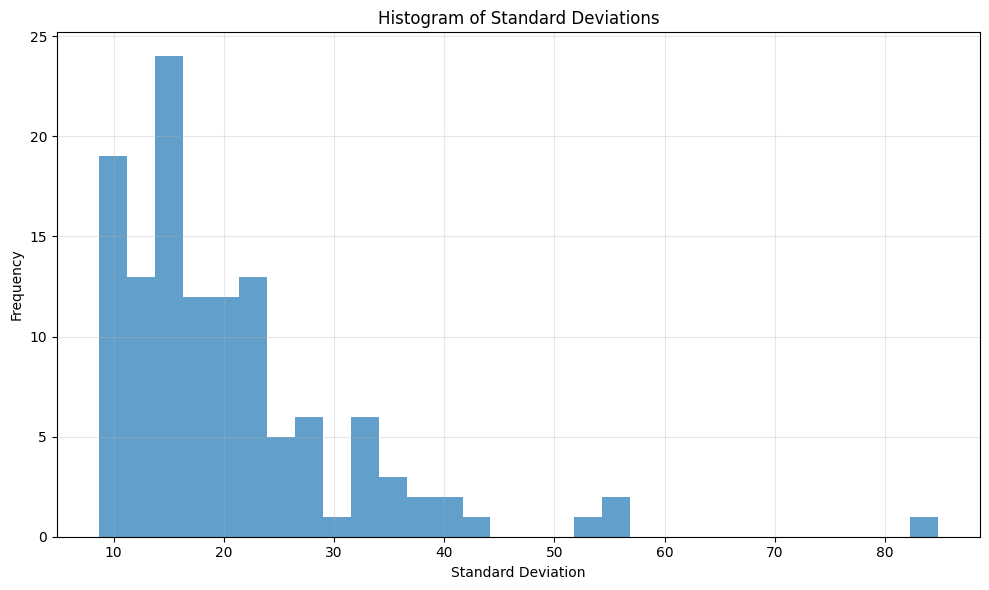

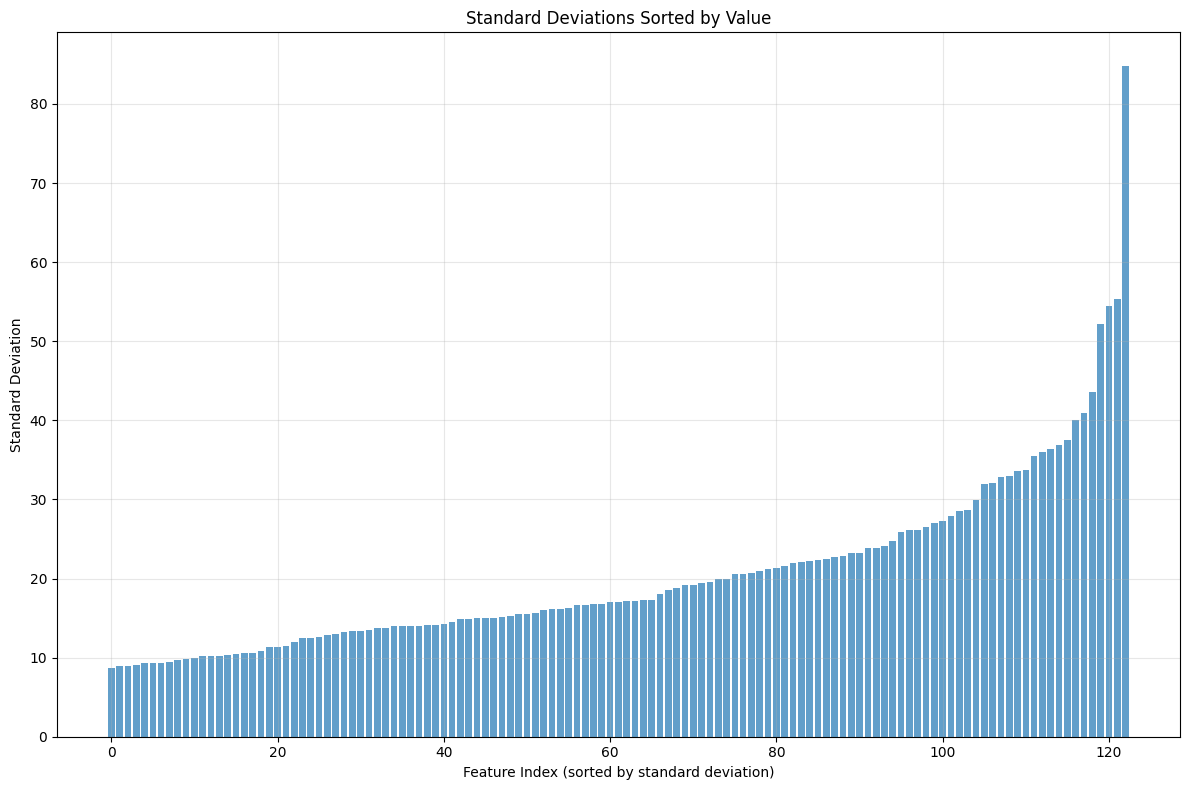

Min standard deviation: 8.65754222869873
Max standard deviation: 84.81404113769531
Mean standard deviation: 20.48973846435547


In [49]:
import matplotlib.pyplot as plt
# Plot histogram of standard deviations
plt.figure(figsize=(10, 6))
stdevs = [idx2stdevs[idx] for idx in sorted(idx2stdevs.keys())]
plt.hist(stdevs, bins=30, alpha=0.7)
plt.title('Histogram of Standard Deviations')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Also plot the distribution of standard deviations with feature names
plt.figure(figsize=(12, 8))
sorted_idxs = sorted(idx2stdevs.keys(), key=lambda x: idx2stdevs[x])
sorted_stdevs = [idx2stdevs[idx] for idx in sorted_idxs]
plt.bar(range(len(sorted_stdevs)), sorted_stdevs, alpha=0.7)
plt.title('Standard Deviations Sorted by Value')
plt.xlabel('Feature Index (sorted by standard deviation)')
plt.ylabel('Standard Deviation')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print some statistics about the standard deviations
print(f"Min standard deviation: {min(stdevs)}")
print(f"Max standard deviation: {max(stdevs)}")
print(f"Mean standard deviation: {sum(stdevs)/len(stdevs)}")


In [50]:
from pathlib import Path
import matplotlib.pyplot as plt
output_folder = Path("deleteme_sae_dist_plots")
output_folder.mkdir(exist_ok=False)
for idx, idx_name in tqdm.tqdm(relevant_idxs_and_names):
    filename = output_folder / (idx_name.replace(".", "_").replace("/", "_") + ".png")
    latents = idx2latents[idx]
    histo_data = latents.cpu().numpy()
    histo_data2 = histo_data[histo_data != 0]
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Set an overall title to the idx_name
    fig.suptitle(f"{idx_name} (idx={idx}) Histogram of Distributions")

    # Plot histogram of all data (histo_data)
    ax1.hist(histo_data, bins=50, alpha=0.7)
    ax1.set_title('Histogram of All Latent Values')
    ax1.set_xlabel('Latent Value')
    ax1.set_ylabel('Frequency')
    ax1.grid(alpha=0.3)

    # Plot histogram of non-zero data (histo_data2)
    ax2.hist(histo_data2, bins=50, alpha=0.7)
    ax2.set_title('Histogram of Non-Zero Latent Values')
    ax2.set_xlabel('Latent Value')
    ax2.set_ylabel('Frequency')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    # plt.show()
    # Save the figure to the specified filename
    plt.savefig(filename)
    plt.close(fig)  # Close the figure to free memory



FileExistsError: [Errno 17] File exists: 'deleteme_sae_dist_plots'

In [51]:
boolean_assignments_in_code_idx = 15_947

In [52]:
import tqdm
# Let's try and display all deez
for idx, idx_name in tqdm.tqdm(relevant_idxs_and_names):
    # template_link =
    # html = get_dashboard_html(sae_release = "gemma-scope-2b-pt-res-canonical", sae_id="layer_20/width_16k/canonical", feature_idx=idx)
    # x = IFrame(html, width=1200, height=600)
    # display(x)
    # "gemma-2-2b", sae_id="20-gemmascope-res-16k"
    print(html_template.format("gemma-2-2b", "20-gemmascope-res-16k", idx))

100%|██████████| 123/123 [00:00<00:00, 57334.90it/s]

https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/10004?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/15947?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/6166?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/2290?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/6223?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/9096?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300
https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/6612?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300
https://neuronpedia.org/gemma-2-2b/20-g

  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([10, 128])


  9%|▉         | 1/11 [00:00<00:03,  3.14it/s]

torch.Size([10, 128])


 18%|█▊        | 2/11 [00:00<00:02,  3.16it/s]

torch.Size([10, 128])


 27%|██▋       | 3/11 [00:00<00:02,  3.17it/s]

torch.Size([10, 128])


 36%|███▋      | 4/11 [00:01<00:02,  3.17it/s]

torch.Size([10, 128])


 45%|████▌     | 5/11 [00:01<00:01,  3.17it/s]

torch.Size([10, 128])


 55%|█████▍    | 6/11 [00:01<00:01,  3.17it/s]

torch.Size([10, 128])


 64%|██████▎   | 7/11 [00:02<00:01,  3.17it/s]

torch.Size([10, 128])


 73%|███████▎  | 8/11 [00:02<00:00,  3.16it/s]

torch.Size([10, 128])


 82%|████████▏ | 9/11 [00:02<00:00,  3.15it/s]

torch.Size([10, 128])


 91%|█████████ | 10/11 [00:03<00:00,  3.15it/s]

torch.Size([10, 128])


100%|██████████| 11/11 [00:03<00:00,  3.15it/s]


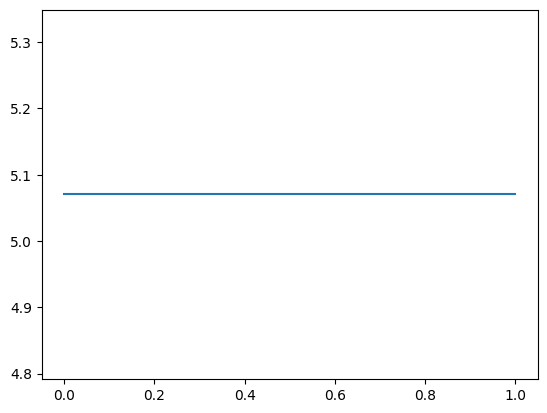

In [67]:
import math
from typing import Dict, Optional
import torch.nn as nn
import copy
class IdxMapQuantizedS(nn.Module):
    def __init__(self, sae: SAE, idx2means: Dict[int, torch.Tensor], threshold_frac: Optional[float] = None, idx2stdevs: Optional[Dict[int, torch.Tensor]] = None):
        super().__init__()
        self.sae = sae
        self.idx2means = copy.deepcopy(idx2means)
        assert threshold_frac is None or 0 <= threshold_frac <= 1
        assert threshold_frac is None or idx2stdevs is not None
        assert idx2stdevs is None or len(idx2stdevs) == len(idx2means)
        # If there is a threshold remove the k highest stadnard deviation idx2menas
        if threshold_frac is not None:
            # Sort the idx2stdevs by standard deviation in descending order
            sorted_stdevs = sorted(idx2stdevs.items(), key=lambda x: x[1], reverse=True)
            length = math.ceil(threshold_frac * len(sorted_stdevs))
            for idx, _ in sorted_stdevs[:length]: # take out highest stdevs
                del self.idx2means[idx]
                
            assert len(self.idx2means) == len(idx2stdevs) - length
            

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 3
        enc = self.sae.encode(x)
        for idx, mean in self.idx2means.items():
            enc[:, :, idx] = enc[:, :, idx].where(enc[:, :, idx] > 0, mean)
        decoded = self.sae.decode(enc)
        assert decoded.shape == x.shape
        return decoded

try:
    del all_quantized
except:
    pass
import gc
gc.collect()
torch.cuda.empty_cache()


losses_avgs = []
thresholds = torch.tensor([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
for threshold in tqdm.tqdm(thresholds):
    less_tokens = tokens[:10] # eh
    print(less_tokens.shape)
    all_quantized = IdxMapQuantizedS(sae, idx2means)
    def saes_hook(mod, inputs, outputs):
        global all_quantized
        assert isinstance(outputs, tuple)
        hidden_states = outputs[0]
        processed = all_quantized(hidden_states)
        return (processed,) + outputs[1:]
    # def saes_pre_hook(mod, inputs):
    #     global all_quantized
    #     assert isinstance(inputs, tuple)
    #     hidden_states = inputs[0]
    #     processed = all_quantized(hidden_states)
    #     return (processed,) + inputs[1:]
    handle = model.model.layers[20].register_forward_hook(saes_hook)
    try:
        batch_size = 50
        losses = []
        sizes = []
        for i in tqdm.trange(0, less_tokens.shape[0], batch_size):
            j = min(i + batch_size, less_tokens.shape[0])
            out = model.forward(less_tokens[i:j], labels=less_tokens[i:j])
            # out.loss
            # out = model(torch.randint(0, 10000, (batch_size, 128), device="cuda"))
            # print(out.loss)
            losses.append(out.loss.item())
            sizes.append(j - i)
            # raise NotImplementedError("Stop here")
    except:
        raise
    finally:
        handle.remove()
        # model.model.layers[20]._forward_hooks.clear()
        # model.model.layers[20]._forward_pre_hooks.clear()
    losses = torch.tensor(losses).float()
    sizes = torch.tensor(sizes).float()
    assert sizes.shape == losses.shape
    sizes /= sizes.sum()
    assert sizes.sum() == 1, f"sizes.sum() = {sizes.sum()}"
    losses = (losses * sizes).sum() # weighted avg
    losses_avgs.append(losses.item())

losses_avgs = torch.tensor(losses_avgs)
assert losses_avgs.shape == thresholds.shape

plt.plot(thresholds, losses_avgs)
plt.show()

In [68]:
print(losses_avgs)

tensor([5.0702, 5.0702, 5.0702, 5.0702, 5.0702, 5.0702, 5.0702, 5.0702, 5.0702,
        5.0702, 5.0702])


100%|██████████| 20/20 [00:58<00:00,  2.94s/it]
/tmp/ipykernel_595464/3604205266.py:79: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  std = values.std().item()


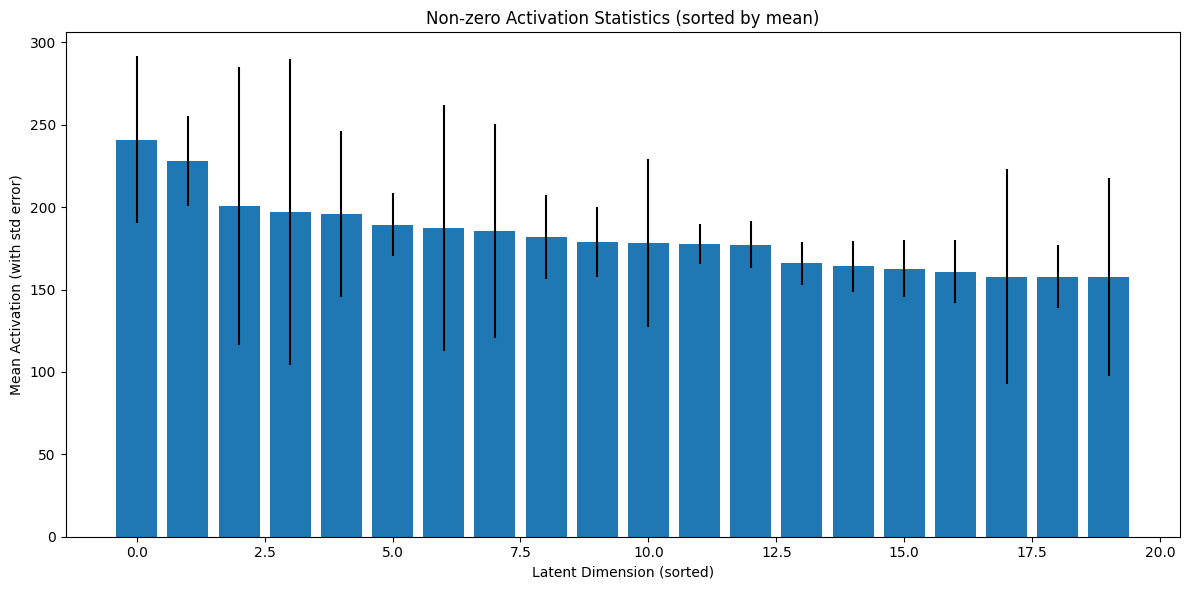

In [71]:
class SparseActivationAnalyzer:
    """
    Analyzes sparse activations from an SAE model, collecting statistics on non-zero activations
    for each latent dimension.

    Generated by Claude 3.7 Max.
    """
    def __init__(self, sae, model, layer_idx=20, batch_size=50):
        self.sae = sae
        self.model = model
        self.layer_idx = layer_idx
        self.batch_size = batch_size
        self.latent_dim = sae.cfg.d_sae
        self.non_zero_activations = [[] for _ in range(self.latent_dim)]
        
    def collect_activations(self, tokens, max_tokens=None):
        """
        Collect non-zero activations for each latent dimension from the given tokens.
        
        Args:
            tokens: Input tokens to process
            max_tokens: Optional limit on number of tokens to process
        """
        if max_tokens is not None:
            tokens = tokens[:max_tokens]
            
        # Set up hook to capture model activations and run SAE encode
        def model_activation_hook(mod, inputs, outputs):
            # Run the SAE encoder on the model's activations
            hidden_states = outputs[0]
            with torch.no_grad():
                sae_acts = self.sae.encode(hidden_states)
                
            # For each latent dimension, collect non-zero activations
            for dim in range(self.latent_dim):
                flat = sae_acts[:, :, dim].flatten()
                non_zeros = flat[flat > 0]
                if len(non_zeros) > 0:
                    self.non_zero_activations[dim].extend(non_zeros.cpu().tolist())
            
            return (hidden_states,) + outputs[1:]
            
        # Register hook on the specified layer
        handle = self.model.model.layers[self.layer_idx].register_forward_hook(model_activation_hook)
        losses = []
        try:
            # Process tokens in batches
            for i in tqdm.trange(0, tokens.shape[0], self.batch_size):
                j = min(i + self.batch_size, tokens.shape[0])
                batch = tokens[i:j]
                assert isinstance(batch, torch.Tensor)
                
                # Run the model with the hook
                with torch.no_grad():
                    # print("Afda;sljhdflakjsdhf")
                    out = self.model.forward(batch, labels=batch) # 
                    # print("sssssssss")
                    losses.append(out.loss.item())
                    # print("?!?!?!?!?!!?")
        
        finally:
            handle.remove()
        losses = torch.tensor(losses).mean().item()
        return losses # ehhh
    
    def compute_statistics(self):
        """
        Compute mean and standard deviation for non-zero activations of each latent dimension.
        
        Returns:
            Dictionary with statistics for each latent dimension
        """
        stats = []
        
        for dim in range(self.latent_dim):
            if len(self.non_zero_activations[dim]) > 0:
                values = torch.tensor(self.non_zero_activations[dim])
                mean = values.mean().item()
                std = values.std().item()
                count = len(values)
                sparsity = count / (self.batch_size * len(self.non_zero_activations))
            else:
                mean = 0.0
                std = 0.0
                count = 0
                sparsity = 0.0
                
            stats.append({
                'dim': dim,
                'mean': mean,
                'std': std,
                'count': count,
                'sparsity': sparsity
            })
        
        return stats
    
    def get_sorted_dimensions(self, sort_by='mean', ascending=False):
        """
        Get latent dimensions sorted by the specified statistic.
        
        Args:
            sort_by: Statistic to sort by ('mean', 'std', 'count', 'sparsity')
            ascending: Whether to sort in ascending order
            
        Returns:
            List of dimension indices sorted by the specified statistic
        """
        stats = self.compute_statistics()
        return sorted(range(self.latent_dim), key=lambda i: stats[i][sort_by], reverse=not ascending)
    
    def plot_statistics(self, sort_by='mean', top_n=None):
        """
        Plot statistics for latent dimensions.
        
        Args:
            sort_by: Statistic to sort by
            top_n: Number of top dimensions to show (None for all)
        """
        stats = self.compute_statistics()
        sorted_dims = self.get_sorted_dimensions(sort_by=sort_by)
        
        if top_n is not None:
            sorted_dims = sorted_dims[:top_n]
            
        means = [stats[dim]['mean'] for dim in sorted_dims]
        stds = [stats[dim]['std'] for dim in sorted_dims]
        
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(sorted_dims)), means, yerr=stds)
        plt.xlabel('Latent Dimension (sorted)')
        plt.ylabel(f'Mean Activation (with std error)')
        plt.title(f'Non-zero Activation Statistics (sorted by {sort_by})')
        plt.tight_layout()
        plt.show()

# Example usage:
analyzer = SparseActivationAnalyzer(sae, model)
analyzer.collect_activations(tokens, max_tokens=1000)
analyzer.plot_statistics(sort_by='mean', top_n=10_000)


16384


/tmp/ipykernel_595464/3604205266.py:79: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  std = values.std().item()


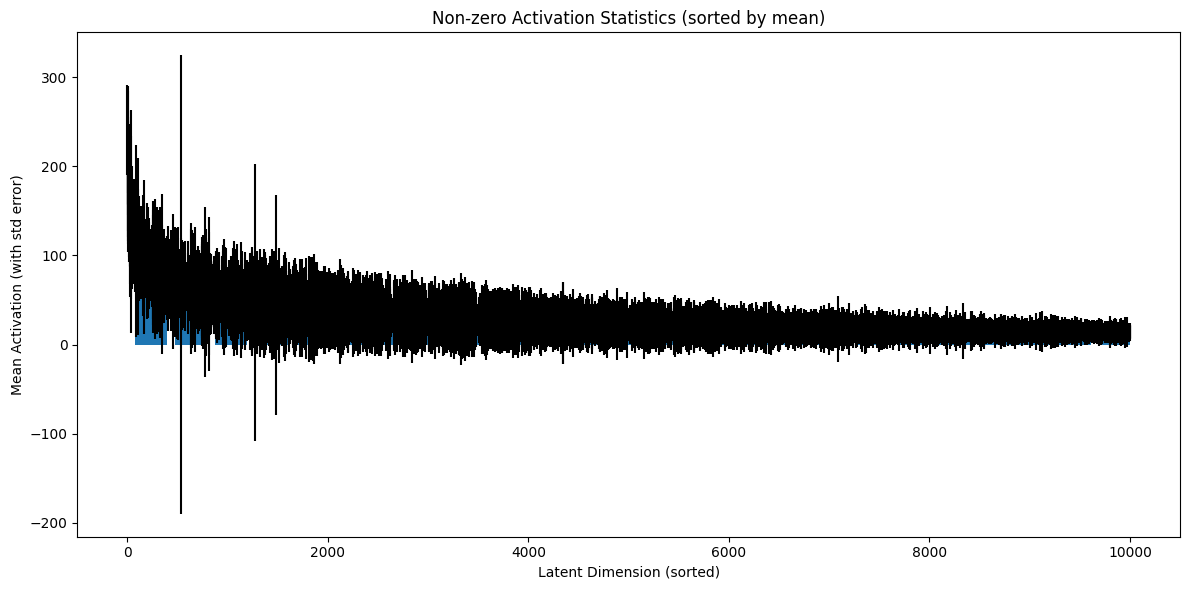

In [72]:
print(len(analyzer.non_zero_activations))
analyzer.plot_statistics(sort_by='mean', top_n=10_000)

/tmp/ipykernel_595464/3604205266.py:79: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  std = values.std().item()


length of idx2stdevs 16384
length of idx2means 16384


100%|██████████| 26/26 [01:41<00:00,  3.90s/it]


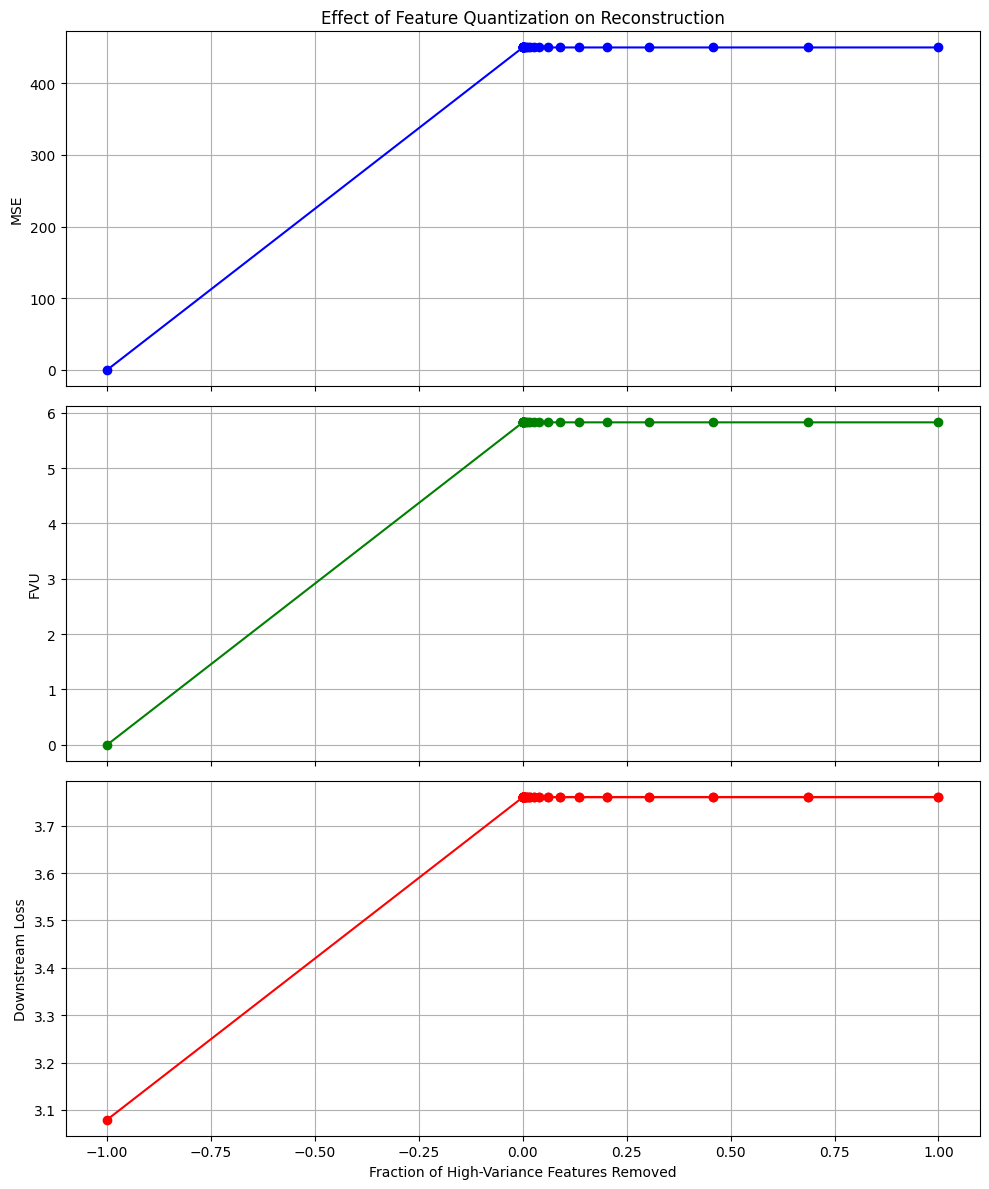

In [103]:
import tqdm
import torch.nn.functional as F
# Let's use the IdxMapQuantizedS class to quantize features based on standard deviation

# First, get the statistics from our analyzer
stats = analyzer.compute_statistics()

# Create dictionaries for means and standard deviations
idx2means = {}
idx2stdevs = {}

for idx in range(sae.cfg.d_sae):
    if idx in stats:
        idx2means[idx] = stats[idx]['mean']
        idx2stdevs[idx] = stats[idx]['std']
    else:
        # For features with no activations, set default values
        idx2means[idx] = 0.0
        idx2stdevs[idx] = float('inf')  # High std to prioritize removal
print("length of idx2stdevs", len(idx2stdevs))
print("length of idx2means", len(idx2means))

class IdxMapQuantizedS(nn.Module):
    def __init__(self, sae: SAE, idx2means: Dict[int, torch.Tensor], threshold_frac: Optional[float] = None, idx2stdevs: Optional[Dict[int, torch.Tensor]] = None):
        super().__init__()
        self.sae = sae
        self.idx2means = copy.deepcopy(idx2means)
        assert threshold_frac is None or 0 <= threshold_frac <= 1
        assert threshold_frac is None or idx2stdevs is not None
        assert idx2stdevs is None or len(idx2stdevs) == len(idx2means)
        # If there is a threshold remove the k highest stadnard deviation idx2menas
        if threshold_frac is not None:
            # Sort the idx2stdevs by standard deviation in descending order
            sorted_stdevs = sorted(idx2stdevs.items(), key=lambda x: x[1], reverse=True)
            length = math.ceil(threshold_frac * len(sorted_stdevs))
            for idx, _ in sorted_stdevs[:length]: # take out highest stdevs
                del self.idx2means[idx]
                
            assert len(self.idx2means) == len(idx2stdevs) - length
            

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 3
        enc = self.sae.encode(x)
        for idx, mean in self.idx2means.items():
            enc[:, :, idx] = enc[:, :, idx].where(enc[:, :, idx] > 0, mean)
        decoded = self.sae.decode(enc)
        assert decoded.shape == x.shape
        return decoded

# Run experiments with different threshold fractions
threshold_fractions = [-1.0] + sorted(
    list(
        set(
            [min(sae.cfg.d_sae, 1.5**i) / sae.cfg.d_sae for i in range(30)]
        )
    )
)
results = []

def create_model_hook(threshold_frac, quantized_model, metrics):
    def hook(mod, inputs):
        # NOTE: pre-hook
        hidden_states = inputs[0]
        with torch.no_grad():
            metrics['n_batches'] += 1
            
            recons = hidden_states
            if quantized_model is not None:
                recons = quantized_model(hidden_states)
            
            mse = F.mse_loss(recons, hidden_states).item()
            variance = torch.var(hidden_states)
            fvu = mse / variance.item()
            
            metrics['total_mse'] += mse
            metrics['total_fvu'] += fvu
        
        if threshold_frac == -1.0:
            return inputs
        return (recons,) + inputs[1:]
    return hook

for threshold_frac in tqdm.tqdm(threshold_fractions, desc="Processing threshold fractions", total=len(threshold_fractions)):
    # Create quantized model with specified threshold
    quantized_model = IdxMapQuantizedS(
        sae=sae,
        idx2means=idx2means,
        threshold_frac=threshold_frac,
        idx2stdevs=idx2stdevs
    ) if threshold_frac != -1.0 else None
    
    # Evaluate reconstruction quality
    batch_size = 50
    
    metrics = {'total_mse': 0, 'total_fvu': 0, 'n_batches': 0}
    hook = create_model_hook(threshold_frac, quantized_model, metrics)
    handle = model.model.layers[21].register_forward_pre_hook(hook)
    
    # Measure downstream loss
    losses = []
    n_tot = 100
    try:
        for i in tqdm.trange(0, min(n_tot, tokens.shape[0]), batch_size):
            j = min(i + batch_size, min(n_tot, tokens.shape[0]))
            batch = tokens[i:j]
            
            with torch.no_grad():
                out = model.forward(batch, labels=batch)
                losses.append(out.loss.item())
    finally:
        handle.remove()
    
    avg_loss = sum(losses) / len(losses)
    avg_mse = metrics['total_mse'] / metrics['n_batches']
    avg_fvu = metrics['total_fvu'] / metrics['n_batches']
    
    # Store results
    results.append({
        'threshold_frac': threshold_frac,
        'num_removed': int(threshold_frac * len(idx2means)),
        'mse': avg_mse,
        'fvu': avg_fvu,
        'loss': avg_loss
    })

# Plot results
threshold_fracs = [r['threshold_frac'] for r in results]
mse_values = [r['mse'] for r in results]
fvu_values = [r['fvu'] for r in results]
loss_values = [r['loss'] for r in results]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# MSE plot
ax1.plot(threshold_fracs, mse_values, 'o-', color='blue')
ax1.set_ylabel('MSE')
ax1.set_title('Effect of Feature Quantization on Reconstruction')
ax1.grid(True)

# FVU plot
ax2.plot(threshold_fracs, fvu_values, 'o-', color='green')
ax2.set_ylabel('FVU')
ax2.grid(True)

# Loss plot
ax3.plot(threshold_fracs, loss_values, 'o-', color='red')
ax3.set_xlabel('Fraction of High-Variance Features Removed')
ax3.set_ylabel('Downstream Loss')
ax3.grid(True)

ax3.plot(threshold_fracs[1:], loss_values[1:], 'o-', color='red')
ax3.set_xlabel('Fraction of High-Variance Features Removed')
ax3.set_ylabel('Downstream Loss')
ax3.grid(True)

plt.tight_layout()
plt.show()


In [104]:
print(json.dumps(results, indent=4))
ax3.plot(threshold_fracs[1:], loss_values[1:], 'o-', color='red')
ax3.set_xlabel('Fraction of High-Variance Features Removed')
ax3.set_ylabel('Downstream Loss')
ax3.grid(True)



[
    {
        "threshold_frac": -1.0,
        "num_removed": -16384,
        "mse": 0.0,
        "fvu": 0.0,
        "loss": 3.0795241594314575
    },
    {
        "threshold_frac": 6.103515625e-05,
        "num_removed": 1,
        "mse": 449.873291015625,
        "fvu": 5.828610741158348,
        "loss": 3.7602940797805786
    },
    {
        "threshold_frac": 9.1552734375e-05,
        "num_removed": 1,
        "mse": 449.873291015625,
        "fvu": 5.828610741158348,
        "loss": 3.7602940797805786
    },
    {
        "threshold_frac": 0.0001373291015625,
        "num_removed": 2,
        "mse": 449.873291015625,
        "fvu": 5.828610741158348,
        "loss": 3.7602940797805786
    },
    {
        "threshold_frac": 0.00020599365234375,
        "num_removed": 3,
        "mse": 449.873291015625,
        "fvu": 5.828610741158348,
        "loss": 3.7602940797805786
    },
    {
        "threshold_frac": 0.000308990478515625,
        "num_removed": 5,
        "mse": 449.8732

/tmp/ipykernel_595464/3604205266.py:79: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  std = values.std().item()


length of idx2stdevs 16384
length of idx2means 16384


100%|██████████| 26/26 [01:41<00:00,  3.89s/it]


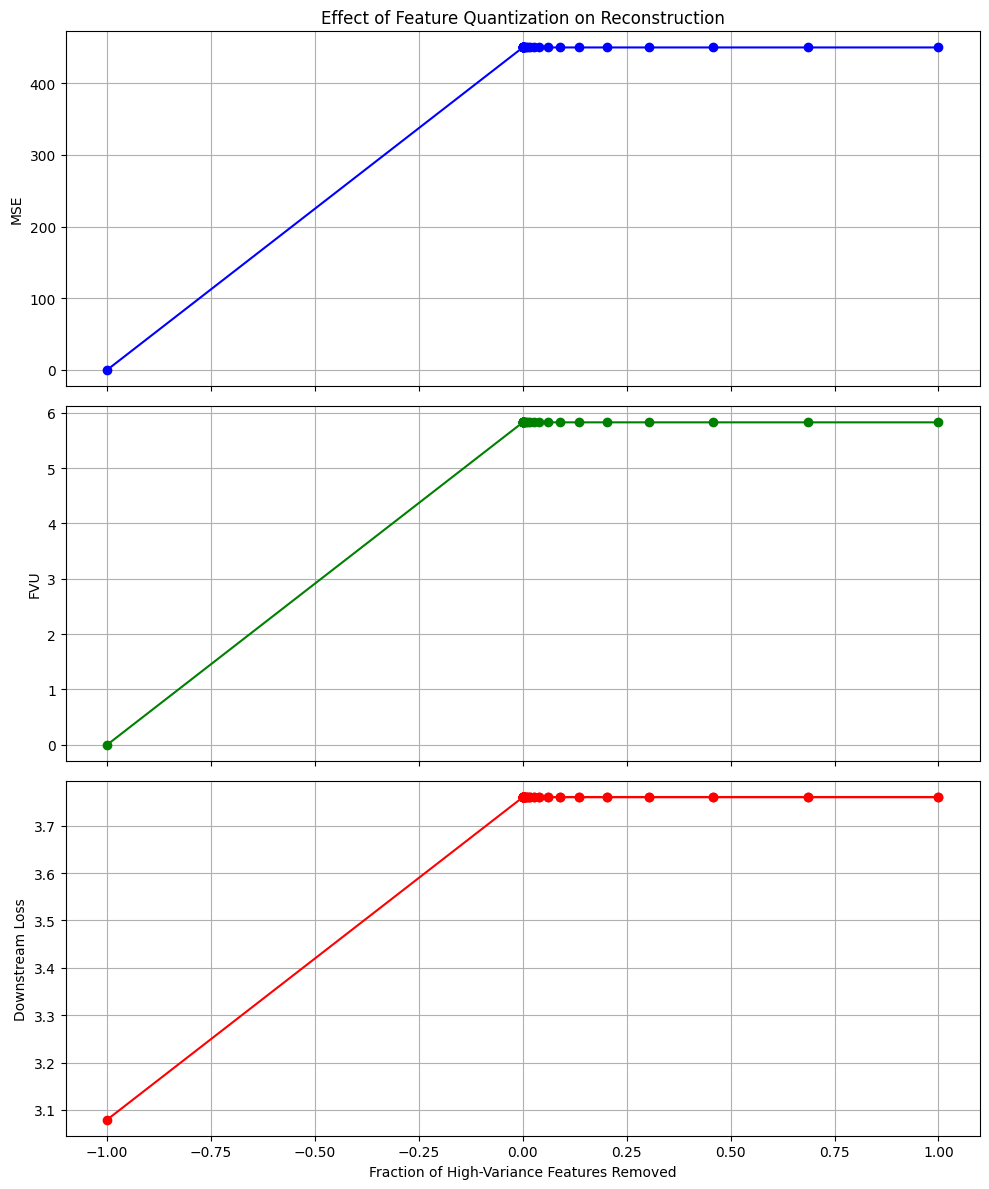

In [ ]:
import tqdm
import torch.nn.functional as F
# Let's use the IdxMapQuantizedS class to quantize features based on standard deviation

# First, get the statistics from our analyzer
stats = analyzer.compute_statistics()

# Create dictionaries for means and standard deviations
idx2means = {}
idx2stdevs = {}

for idx in range(sae.cfg.d_sae):
    if idx in stats:
        idx2means[idx] = stats[idx]['mean']
        idx2stdevs[idx] = stats[idx]['std']
    else:
        # For features with no activations, set default values
        idx2means[idx] = 0.0
        idx2stdevs[idx] = float('inf')  # High std to prioritize removal
print("length of idx2stdevs", len(idx2stdevs))
print("length of idx2means", len(idx2means))

class IdxMapQuantizedS(nn.Module):
    def __init__(self, sae: SAE, idx2means: Dict[int, torch.Tensor], threshold_frac: Optional[float] = None, idx2stdevs: Optional[Dict[int, torch.Tensor]] = None):
        super().__init__()
        self.sae = sae
        self.idx2means = copy.deepcopy(idx2means)
        assert threshold_frac is None or 0 <= threshold_frac <= 1
        assert threshold_frac is None or idx2stdevs is not None
        assert idx2stdevs is None or len(idx2stdevs) == len(idx2means)
        # If there is a threshold remove the k highest stadnard deviation idx2menas
        if threshold_frac is not None:
            # Sort the idx2stdevs by standard deviation in descending order
            sorted_stdevs = sorted(idx2stdevs.items(), key=lambda x: x[1], reverse=True)
            length = math.ceil(threshold_frac * len(sorted_stdevs))
            for idx, _ in sorted_stdevs[:length]: # take out highest stdevs
                del self.idx2means[idx]
                
            assert len(self.idx2means) == len(idx2stdevs) - length
            

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 3
        enc = self.sae.encode(x)
        for idx, mean in self.idx2means.items():
            enc[:, :, idx] = enc[:, :, idx].where(enc[:, :, idx] > 0, mean)
        decoded = self.sae.decode(enc)
        assert decoded.shape == x.shape
        return decoded

# Run experiments with different threshold fractions
threshold_fractions = [-1.0] + sorted(
    list(
        set(
            [min(sae.cfg.d_sae, 1.5**i) / sae.cfg.d_sae for i in range(30)]
        )
    )
)
results = []

def create_model_hook(threshold_frac, quantized_model, metrics):
    def hook(mod, inputs, outputs):
        hidden_states = outputs[0]
        with torch.no_grad():
            metrics['n_batches'] += 1
            
            recons = hidden_states
            if quantized_model is not None:
                recons = quantized_model(hidden_states)
            
            mse = F.mse_loss(recons, hidden_states).item()
            variance = torch.var(hidden_states)
            fvu = mse / variance.item()
            
            metrics['total_mse'] += mse
            metrics['total_fvu'] += fvu
        
        if threshold_frac == -1.0:
            return outputs
        return (recons,) + outputs[1:]
    return hook

for threshold_frac in tqdm.tqdm(threshold_fractions):
    # Create quantized model with specified threshold
    quantized_model = IdxMapQuantizedS(
        sae=sae,
        idx2means=idx2means,
        threshold_frac=threshold_frac,
        idx2stdevs=idx2stdevs
    ) if threshold_frac != -1.0 else None
    
    # Evaluate reconstruction quality
    batch_size = 50
    
    metrics = {'total_mse': 0, 'total_fvu': 0, 'n_batches': 0}
    hook = create_model_hook(threshold_frac, quantized_model, metrics)
    handle = model.model.layers[20].register_forward_hook(hook)
    
    # Measure downstream loss
    losses = []
    n_tot = 100
    try:
        for i in tqdm.trange(0, min(n_tot, tokens.shape[0]), batch_size):
            j = min(i + batch_size, min(n_tot, tokens.shape[0]))
            batch = tokens[i:j]
            
            with torch.no_grad():
                out = model.forward(batch, labels=batch)
                losses.append(out.loss.item())
    finally:
        handle.remove()
    
    avg_loss = sum(losses) / len(losses)
    avg_mse = metrics['total_mse'] / metrics['n_batches']
    avg_fvu = metrics['total_fvu'] / metrics['n_batches']
    
    # Store results
    results.append({
        'threshold_frac': threshold_frac,
        'num_removed': int(threshold_frac * len(idx2means)),
        'mse': avg_mse,
        'fvu': avg_fvu,
        'loss': avg_loss
    })

# Plot results
threshold_fracs = [r['threshold_frac'] for r in results]
mse_values = [r['mse'] for r in results]
fvu_values = [r['fvu'] for r in results]
loss_values = [r['loss'] for r in results]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# MSE plot
ax1.plot(threshold_fracs, mse_values, 'o-', color='blue')
ax1.set_ylabel('MSE')
ax1.set_title('Effect of Feature Quantization on Reconstruction')
ax1.grid(True)

# FVU plot
ax2.plot(threshold_fracs, fvu_values, 'o-', color='green')
ax2.set_ylabel('FVU')
ax2.grid(True)

# Loss plot
ax3.plot(threshold_fracs, loss_values, 'o-', color='red')
ax3.set_xlabel('Fraction of High-Variance Features Removed')
ax3.set_ylabel('Downstream Loss')
ax3.grid(True)

ax3.plot(threshold_fracs[1:], loss_values[1:], 'o-', color='red')
ax3.set_xlabel('Fraction of High-Variance Features Removed')
ax3.set_ylabel('Downstream Loss')
ax3.grid(True)

plt.tight_layout()
plt.show()


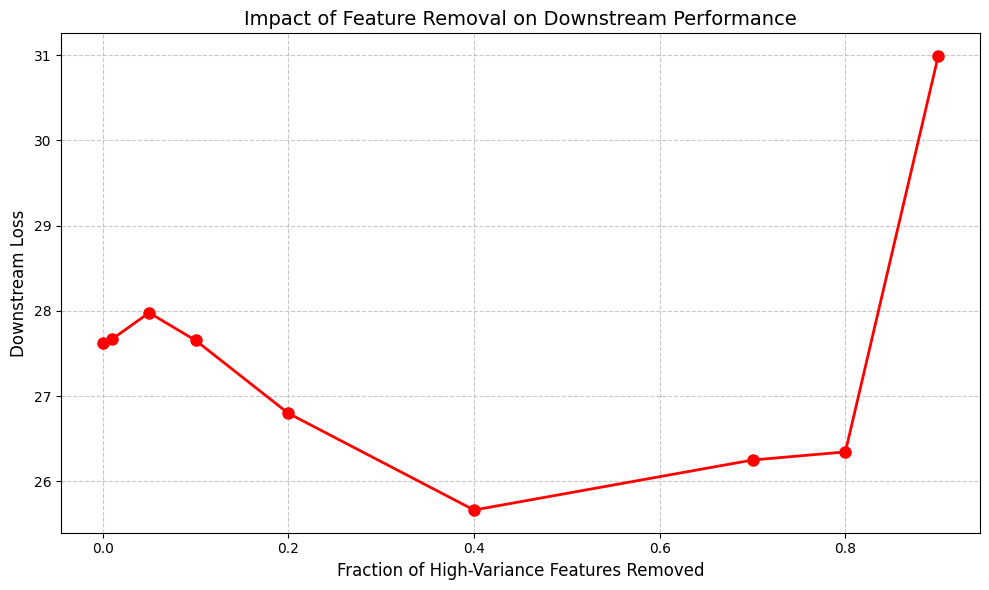

In [98]:
# Create a new figure for this plot
plt.figure(figsize=(10, 6))
plt.plot(threshold_fracs[1:], loss_values[1:], 'o-', color='red', linewidth=2, markersize=8)
plt.xlabel('Fraction of High-Variance Features Removed', fontsize=12)
plt.ylabel('Downstream Loss', fontsize=12)
plt.title('Impact of Feature Removal on Downstream Performance', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()